# Colab setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/ML/Speech-Emotion-Recognition/Paper

/content/drive/MyDrive/ML/Speech-Emotion-Recognition/Paper


In [3]:
! pip install tensorflow-io==0.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.1 MB 1.2 MB/s 
     |████████████████████████████████| 2.1 MB 70.3 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.26.0
    Uninstalling tensorflow-io-gcs-filesystem-0.26.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.26.0


# Imports and Deterministic Behaviour

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import data_operations as data_ops
import data_visualization as data_vis

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D,  MaxPooling1D, BatchNormalization, GlobalMaxPooling1D

import pandas as pd

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATA_DIR = "./data/SAVEE"

TRAIN_SIZE, VAL_SIZE, TEST_SIZE = (300, 100, 80)

SAMPLE_RATE_HZ = 44100

# Load audio and Get Label functions

In [3]:
def get_label(file_path):
  parts = re.sub('.+\_|[0-9]+.wav', '', file_path)
  return parts

def get_speaker_name(file_path):
  parts = re.sub('.*[/]+|\_|[a-z]+[0-9]+.wav', '', file_path)
  return parts

In [4]:
filenames = [f'{DATA_DIR}/{p}' for p in os.listdir(DATA_DIR)]
labels_true = list(map(get_label, filenames))
labels = pd.get_dummies(labels_true).to_numpy()
df = pd.DataFrame({'filenames': filenames, 'speaker': map(get_speaker_name, filenames), 'label': labels_true})
df = pd.get_dummies(df['label'], prefix="label").join(df[['filenames', 'speaker', 'label']])
one_hot_lables = [col for col in df if col.startswith('label_')]

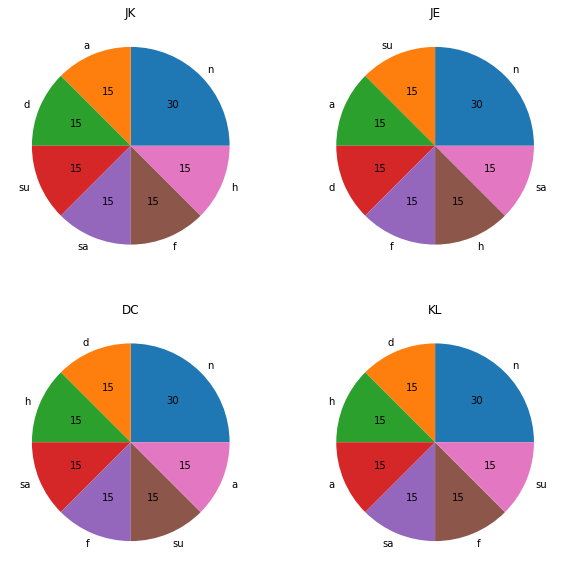

In [5]:
data_vis.speaker_pie_plot(df)

In [6]:
one_hot_lables

['label_a', 'label_d', 'label_f', 'label_h', 'label_n', 'label_sa', 'label_su']

In [7]:
test_files, test_labels = np.array([]), np.array([])
train_files, train_labels = np.array([]), np.array([])
val_files, val_labels = np.array([]), np.array([])

for speaker in df['speaker'].unique():
    data = df[df['speaker'] == speaker]
    
    #  take 20 samples per speaker for test set
    for train_val_index, test_index in StratifiedShuffleSplit(n_splits=10, test_size=20, random_state=seed).split(data['filenames'].to_numpy(), data['label'].to_numpy()):
        train_val_candidate_f, test_candidate_f = data['filenames'].to_numpy()[train_val_index], data['filenames'].to_numpy()[test_index]
        train_val_candidate_l, test_candidate_l = data[one_hot_lables].to_numpy()[train_val_index], data[one_hot_lables].to_numpy()[test_index]


    #  take 20 samples per speaker for val set
    for train_index, val_index in StratifiedShuffleSplit(n_splits=10, test_size=25, random_state=seed).split(train_val_candidate_f, train_val_candidate_l):
        train_candidate_f, val_candidate_f = train_val_candidate_f[train_index], train_val_candidate_f[val_index]
        train_candidate_l, val_candidate_l = train_val_candidate_l[train_index], train_val_candidate_l[val_index]

    test_files = np.append(test_files, test_candidate_f)
    test_labels = np.append(test_labels, test_candidate_l)

    train_files = np.append(train_files, train_candidate_f)
    train_labels = np.append(train_labels, train_candidate_l)

    val_files = np.append(val_files, val_candidate_f)
    val_labels = np.append(val_labels, val_candidate_l)

test_labels = np.reshape(test_labels, (-1, len(one_hot_lables)))
train_labels = np.reshape(train_labels, (-1, len(one_hot_lables)))
val_labels = np.reshape(val_labels, (-1, len(one_hot_lables)))

In [8]:
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

print(train_files[0], train_labels[0])
print(val_files[0], val_labels[0])
print(test_files[0], test_labels[0])

Training set size 300
Validation set size 100
Test set size 80
./data/SAVEE/JK_n26.wav [0. 0. 0. 0. 1. 0. 0.]
./data/SAVEE/JK_n28.wav [0. 0. 0. 0. 1. 0. 0.]
./data/SAVEE/JK_a15.wav [1. 0. 0. 0. 0. 0. 0.]


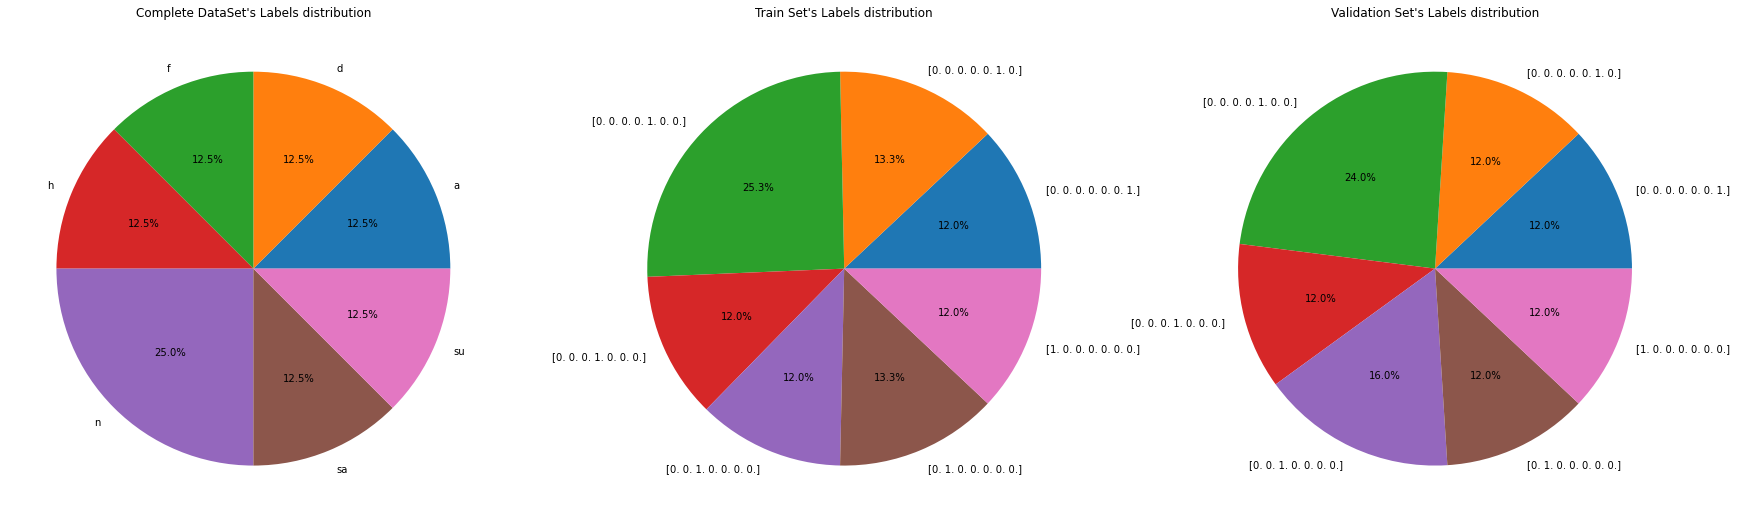

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[0].set_title("Complete DataSet's Labels distribution")
axes[0].pie(np.unique(labels_true, return_counts=True)[1], labels=np.unique(labels_true), autopct='%1.1f%%')
axes[1].set_title("Train Set's Labels distribution")
axes[1].pie(np.unique(list(map(str, train_labels)), return_counts=True)[1], labels=np.unique(list(map(str, train_labels))), autopct='%1.1f%%')
axes[2].set_title("Validation Set's Labels distribution")
axes[2].pie(np.unique(list(map(str, val_labels)), return_counts=True)[1], labels=np.unique(list(map(str, val_labels))), autopct='%1.1f%%')
plt.show()

In [10]:
operations = [
    data_ops.ReadFile(),
    data_ops.DecodeWav(),
    data_ops.Squeeze(),
    data_ops.Crop(SAMPLE_RATE_HZ * 8),
    data_ops.ZeroPad(SAMPLE_RATE_HZ * 8),
    data_ops.CastToFloat(),
    data_ops.Reshape((SAMPLE_RATE_HZ * 8, 1))
]

train_ds = tfio.audio.AudioIODataset.from_tensor_slices((train_files, train_labels))
val_ds = tfio.audio.AudioIODataset.from_tensor_slices((val_files, val_labels))

In [11]:
for o in operations:
    train_ds = train_ds.map(o, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(o, num_parallel_calls=tf.data.AUTOTUNE)

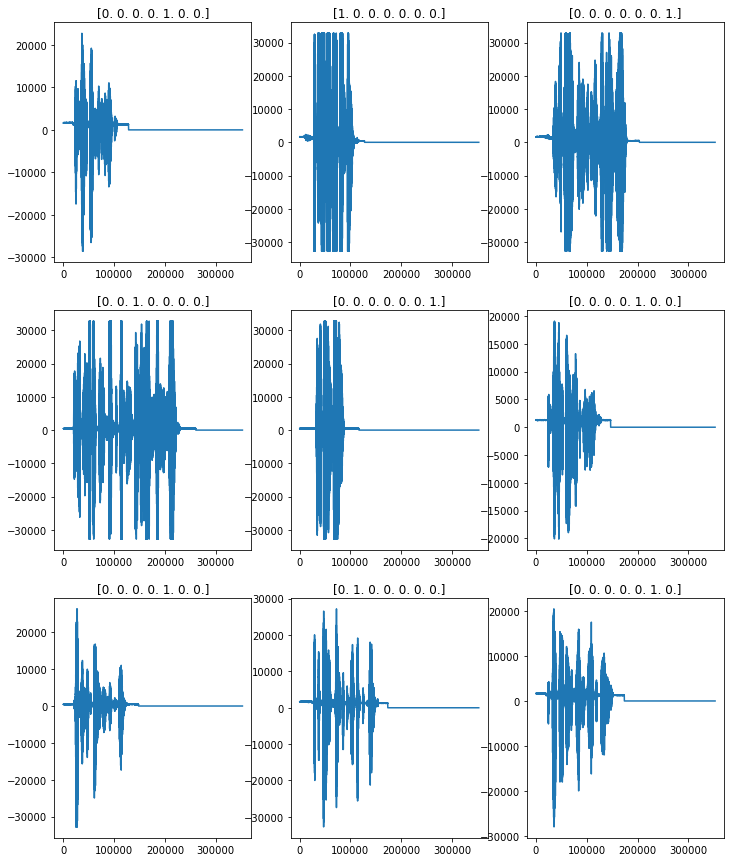

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 15))

for i, (audio, label) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  label = np.array_str(label.numpy())
  ax.set_title(label)

plt.show()

## CNN Architecture
 * 6x 1D + Batch norm + max pooling
 * 1x 1D + Batch norm + global max pooling
 * 2x dense layer

In [ ]:
first_filter_size =  (32, 21)

filters = [64, 128, 256, 512, 1024]
sizes = [19, 17, 15, 13, 11]

middle_filters_size = list(zip(filters, sizes))
last_filter_size =  (1024, 9)

activation= 'relu'
pool_size = 2

In [ ]:
model = Sequential()

# first layer
# input shape (None, n) = variable-length sequences of n-dimensional vectors
model.add(Conv1D(first_filter_size[0], first_filter_size[1], activation = activation, input_shape=(SAMPLE_RATE_HZ * 8, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size = pool_size))

# middle layers
for (filter_size, kernel_size) in middle_filters_size:
    model.add(Conv1D(filter_size, kernel_size, activation = activation))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = pool_size))

# last layer
model.add(Conv1D(last_filter_size[0], last_filter_size[1], activation = activation))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

# model.add(Flatten())
model.add(Dense(128, activation=activation))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 352780, 32)        704       
                                                                 
 batch_normalization (BatchN  (None, 352780, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 176390, 32)       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 176372, 64)        38976     
                                                                 
 batch_normalization_1 (Batc  (None, 176372, 64)       256       
 hNormalization)                                                 
                                                        

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_ds = train_ds.batch(8)
val_ds = val_ds.batch(8)

EPOCHS = 400

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./tmp/checkpoint')

In [ ]:
# model.fit(train_files['padded'].map(lambda x : tf.convert_to_tensor(x.numpy())), train_files['label'], epochs=10, validation_data=(val_files['padded'].map(lambda x : tf.convert_to_tensor(x.numpy())), val_files['label']))
model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint_callback])

Epoch 1/400
38/38 [==============================] - 177s 4s/step - loss: 5.9049 - accuracy: 0.2600 - val_loss: 81.8404 - val_accuracy: 0.1300
Epoch 2/400
38/38 [==============================] - 131s 3s/step - loss: 2.6750 - accuracy: 0.2800 - val_loss: 7.9239 - val_accuracy: 0.1300
Epoch 3/400
38/38 [==============================] - 132s 3s/step - loss: 2.2317 - accuracy: 0.2567 - val_loss: 3.8971 - val_accuracy: 0.1800
Epoch 4/400
38/38 [==============================] - 131s 3s/step - loss: 2.0639 - accuracy: 0.3033 - val_loss: 2.3602 - val_accuracy: 0.2700
Epoch 5/400
38/38 [==============================] - 132s 3s/step - loss: 1.9626 - accuracy: 0.3300 - val_loss: 1.8392 - val_accuracy: 0.2400
Epoch 6/400
38/38 [==============================] - 131s 3s/step - loss: 1.9171 - accuracy: 0.3433 - val_loss: 1.8818 - val_accuracy: 0.3000
Epoch 7/400
38/38 [==============================] - 132s 3s/step - loss: 1.9163 - accuracy: 0.3167 - val_loss: 1.8033 - val_accuracy: 0.3000
Epoch